# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

_Additional Reference_: MCMC Tutorial - https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

### Student Information

_Full Name (Last Name, First Name)_: Daffon, David\
_Student No._: 2021-04594 \
_Section_: THY-TX-2

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name: David D. Daffon**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

#### Preliminaries

In [6]:
!pip install emcee
!pip install corner

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

import emcee
import corner

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After my preliminary imports, I then loaded the .csv files into their respective dataframes.

In [8]:
f_path = "/content/drive/My Drive/c2_dataset/"

ligo = pd.read_csv(f_path + "LIGO.csv")
lisa = pd.read_csv(f_path + "LISA.csv")
et = pd.read_csv(f_path + "ET.csv")

Afterwards, I took the dataframe columns and stored them as lists with the recommended variable names.

In [9]:
zLIGO = ligo["zLIGO"] # splitting the LIGO dataframe into the needed lists for plotting and other functions
dlLIGO = ligo["dlLIGO"]
errLIGO = ligo["errLIGO"]

zLISA = lisa["zLISA"] # splitting the LISA dataframe into the needed lists for plotting and other functions
dlLISA = lisa["dlLISA"]
errLISA = lisa["errLISA"]

zET = et["zET"] # splitting the ET dataframe into the needed lists for plotting and other functions
dlET = et["dlET"]
errET = et["errET"]

By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

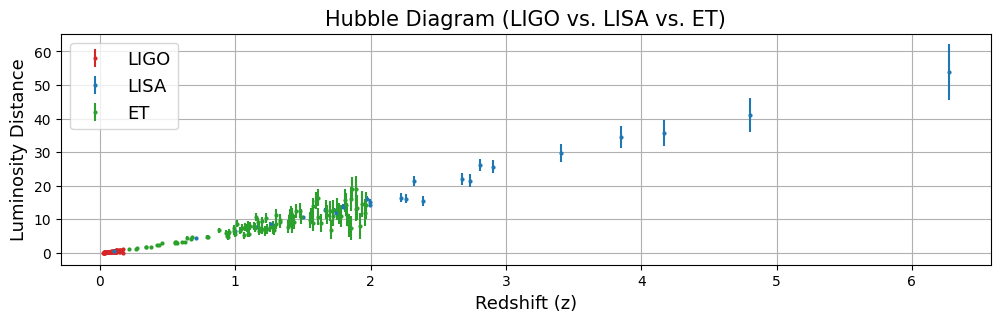

In [10]:
plt.figure(figsize=(12, 3)) # setting figure dimensions

plt.errorbar(zLIGO, dlLIGO, yerr=errLIGO, fmt='o', color='C3', markersize=2, label='LIGO') # errorbar plot for LIGO
plt.errorbar(zLISA, dlLISA, yerr=errLISA, fmt='o', color='C0', markersize=2, label='LISA') # errorbar plot for LISA
plt.errorbar(zET, dlET, yerr=errET, fmt='o', color='C2', markersize=2, label='ET') # errorbar plot for ET

plt.title('Hubble Diagram (LIGO vs. LISA vs. ET)', fontsize=15) # other plotting operations
plt.xlabel('Redshift (z)', fontsize=13)
plt.ylabel('Luminosity Distance', fontsize=13)
plt.legend(fontsize=13)
plt.grid()

From the Hubble diagram, we see the distribution of our samples from the three sources. The LIGO samples seem to be concentrated at very low redshift and luminosity distance. Furthermore, the errorbars for the LIGO samples are very small and not easily seen compared to the other two signals.

The LISA sample is more spread out than the LIGO sample, and the errorbars are more visible, indicating a greater proportion of error. The samples also take up more of the diagram space: reaching up to z=2 redshift and a luminosity distance of 20 units.

Finally, the ET samples are the most spread out, ranging from low to high redshift z, and from near-zero to near-60 units of luminosity distance. It is also apparent how spread apart the samples are.

Interestingly, for the LISA and ET samples (the only ones with visible errorbars) the errorbars seem to grow (meaning error increases) as the samples approach higher redshift and luminosity distance.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [11]:
from astropy.cosmology import FlatLambdaCDM # preliminaries

In [12]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))
# ----------------------------------------------------------------- code cells above are given. Below are mine: --------------------------------------------------

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0): # I defined this function to act just like the above functions, changing the variable names accordingly
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dlET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(H0, Om0): # I defined this function to act just like the above functions, changing the variable names accordingly
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) + chi2ET_lcdm(H0, Om0))

I then defined more functions to deal facilitate the MCMC using the emcee library.

In [13]:
def lnprob_LIGO(x): # to reconcile the required tuple input of the likelihood functions, we create the following functions, one for each likelihood function
  H0, Om0 = x
  return llikeLIGO_lcdm(H0, Om0)

def lnprob_LIGOLISA(x):
  H0, Om0 = x
  return llikeLIGOLISA_lcdm(H0, Om0)

def lnprob_LIGOLISAET(x):
  H0, Om0 = x
  return llikeLIGOLISAET_lcdm(H0, Om0)

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can try the ff. parameters-- number of walkers (nwalkers) of 100 and number of iterations (niter) of 1,000 and number of burn-in samples (nburn) of 100.

Note that the number of dimensions (ndim) is the number of parameters, equal to 2.

For the methodology of stepping from one place of the grid to another, you can use:

    dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
    initial = np.array([70., 0.3])
    p0 = [initial + dres * np.random.randn(ndim) for i in range(nwalkers)]

For the 'lnprob' function equivalent, you can define (for example):

    def lnprob(x):
      '''params: H0, Om0 = x0, x1'''
      return llikeLIGOLISA_lcdm(x[0], x[1])

Also note that because in our definition of likelihood functions, the data is ``hard-coded'', you do not need to use the "args" keyword in the emcee.EnsembleSampler command.

MCMC setup

In [14]:
nwalkers = 100 # declaring variables for the parameters
niter = 1000
nburn = 100
ndim = 2

dres = [0.1, 0.003] # preliminaries for the MCMC
initial = np.array([70., 0.3])
p0 = [initial + dres * np.random.randn(ndim) for i in range(nwalkers)]

MCMC run for LIGO samples

In [15]:
sampler_ligo = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGO) # performing MCMC using emcee and its built-in functions on the LIGO samples
sampler_ligo.run_mcmc(p0, niter, progress=True)
samples_ligo = sampler_ligo.get_chain()

100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


MCMC run for LIGO + LISA samples

In [16]:
sampler_ligolisa = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGOLISA) # performing MCMC on the LIGO + LISA samples
sampler_ligolisa.run_mcmc(p0, niter, progress=True)
samples_ligolisa = sampler_ligolisa.get_chain()

100%|██████████| 1000/1000 [08:03<00:00,  2.07it/s]


MCMC run for LIGO + LISA + ET samples

In [17]:
sampler_ligolisaet = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGOLISAET) # performing MCMC on the LIGO + LISA + ET samples
sampler_ligolisaet.run_mcmc(p0, niter, progress=True)
samples_ligolisaet = sampler_ligolisaet.get_chain()

100%|██████████| 1000/1000 [12:31<00:00,  1.33it/s]


#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


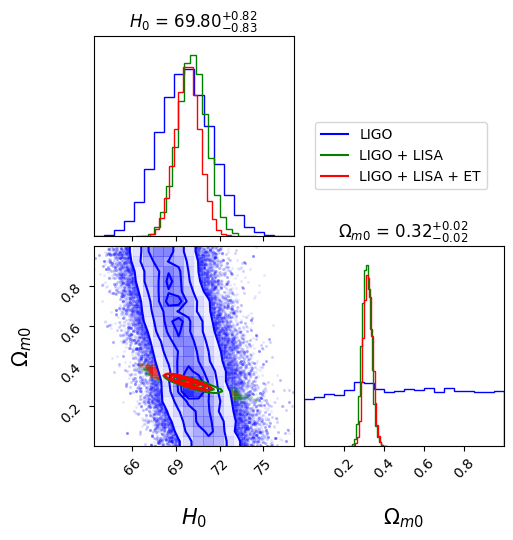

In [18]:
labels = [r'$H_{0}$', '$\Omega_{m0}$'] # defining labels

fig1 = corner.corner(samples_ligo, # creating corner plots with LIGO samples
              labels=labels,
              color='blue',
              show_titles=True,
              label_kwargs={"fontsize": 15},
              title_kwargs={"fontsize": 12})
fig2 = corner.corner(samples_ligolisa, # creating corner plots with LIGO + LISA samples
              labels=labels,
              fig=fig1,
              color='green',
              show_titles=True,
              label_kwargs={"fontsize": 15},
              title_kwargs={"fontsize": 12})
fig3 = corner.corner(samples_ligolisaet, # creating corner plots with LIGO + LISA + ET samples
              labels=labels,
              fig=fig2,
              color='red',
              show_titles=True,
              label_kwargs={"fontsize": 15},
              title_kwargs={"fontsize": 12})

blue_line = mlines.Line2D([], [], color='blue', label='LIGO') # setting up the makeshift legend
green_line = mlines.Line2D([], [], color='green', label='LIGO + LISA')
red_line = mlines.Line2D([], [], color='red', label='LIGO + LISA + ET')

plt.legend(handles=[blue_line, green_line, red_line], bbox_to_anchor=(0.95, 1.25), loc=4) # plotting the makeshift legend
plt.show() # displaying plot

From the figure above, we see that the constraints created with the LIGO samples are wider and therefore not as effective. The "guesses" are not as precise and/or accurate and cover a wider range of values. When we turn to the LIGO + LISA samples, the constraints improve and there is a sort of "narrowing into" the value we try to find. Finally, when all three sample datasets, LIGO + LISA + ET, are used, we yield the best results and the tightest constraints.  